# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [4]:
# Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
%matplotlib inline
import datetime
import pickle



In [5]:
def load_data():
    """
    Read JSON files into pandas DataFrames.

    Reads the 'portfolio.json', 'profile.json', and 'transcript.json' files
    from the 'dataset' directory into pandas DataFrames.

    Returns:
    portfolio (DataFrame): DataFrame containing portfolio data.
    profile (DataFrame): DataFrame containing profile data.
    transcript (DataFrame): DataFrame containing transcript data.
    """
    portfolio = pd.read_json('dataset/portfolio.json', orient='records', lines=True)
    profile = pd.read_json('dataset/profile.json', orient='records', lines=True)
    transcript = pd.read_json('dataset/transcript.json', orient='records', lines=True)
    
    return portfolio, profile, transcript

# Usage
portfolio, profile, transcript = load_data()


In [6]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
def cleaning_portfolio(portfolio):
    '''
    Clean and preprocess the portfolio DataFrame.

    Args:
    - portfolio: DataFrame containing portfolio data to be cleaned.

    Returns:
    - portfolio: DataFrame with cleaned portfolio data.
    '''
    # Create a copy of the DataFrame
    portfolio_cleaned = portfolio.copy()
    
    # Convert duration from days to hours
    portfolio_cleaned['duration_hours'] = portfolio_cleaned['duration'] * 24
    
    # Apply one-hot encoding to the channels column
    portfolio_cleaned['web'] = portfolio_cleaned['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio_cleaned['email'] = portfolio_cleaned['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio_cleaned['mobile'] = portfolio_cleaned['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio_cleaned['social'] = portfolio_cleaned['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # Apply one-hot encoding to the offer_type column
    offer_type_encoded = pd.get_dummies(portfolio_cleaned['offer_type'])
    
    # Drop the channels and offer_type columns
    portfolio_cleaned.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # Merge the DataFrame with one-hot encoded offer types
    portfolio_cleaned = pd.concat([portfolio_cleaned, offer_type_encoded], axis=1, sort=False)
   
    
    return portfolio_cleaned

cleaned_portfolio = cleaning_portfolio(portfolio)


In [10]:
cleaned_portfolio.head()

,reward,difficulty,duration,id,duration_hours,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,168,0,1,1,1,True,False,False
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,120,1,1,1,1,True,False,False
2,0,0,4,3f207df678b143eea3cee63160fa8bed,96,1,1,1,0,False,False,True
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,1,1,1,0,True,False,False
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,1,1,0,0,False,True,False


In [11]:
def cleaning_profile(profile):
    '''
    Cleanse the profile DataFrame.

    Args:
    - profile: DataFrame to be cleansed.

    Returns:
    - cleaned_profile: The sanitized DataFrame.
    '''
    # Replace missing values encoded as 118 with NaN
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # Drop rows with missing values
    profile.dropna(inplace=True)
    
    # Convert 'became_member_on' column to datetime format
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    
    # Calculate the number of days since the user became a member of Starbucks
    min_registration_date = profile['became_member_on'].min()
    profile['memberdays'] = (profile['became_member_on'] - min_registration_date).dt.days
    
    return profile

# Usage
profile = cleaning_profile(profile)


In [12]:
profile.head()

,gender,age,id,became_member_on,income,memberdays
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1447
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1380
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1732
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1656
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1566


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'became_member_on'}>],
       [<Axes: title={'center': 'income'}>,
        <Axes: title={'center': 'memberdays'}>]], dtype=object)

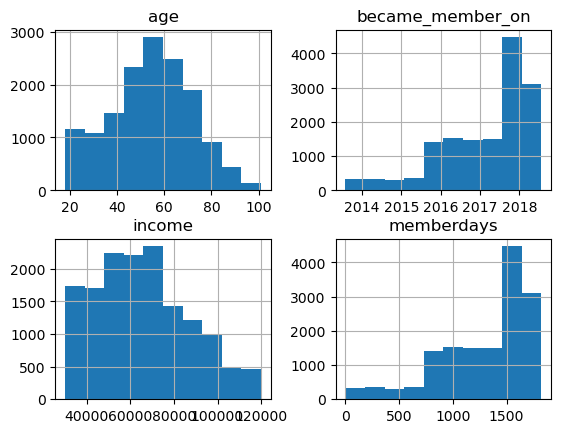

In [13]:
profile.hist()

In [14]:
# explore transcript
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [15]:
# select one user and explore the transcript records
transcript[transcript['person']=='a03223e636434f42ac4c3df47e8bac43']

,person,event,value,time
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
15562,a03223e636434f42ac4c3df47e8bac43,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},6
90553,a03223e636434f42ac4c3df47e8bac43,transaction,{'amount': 1.09},234
97700,a03223e636434f42ac4c3df47e8bac43,transaction,{'amount': 3.5},264
110829,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
123539,a03223e636434f42ac4c3df47e8bac43,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
150599,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},408
201573,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},504
245125,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},576
277104,a03223e636434f42ac4c3df47e8bac43,transaction,{'amount': 0.06},612


In [16]:
def clean_transcript(transcript):
    '''
    Clean the transcript dataframe and extract offer-related records
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # Extract rows related to offer actions (offer received, offer viewed, offer completed)
    offer = transcript[transcript['event'].isin(['offer received', 'offer viewed', 'offer completed'])]
    
    # Extract the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x.get('offer id') if ('offer id' in x) else x.get('offer_id'))
    
    return offer
offer = clean_transcript(transcript)


C:\Users\bonzoi\AppData\Local\Temp\ipykernel_17352\2584291400.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer['offer_id'] = offer['value'].apply(lambda x: x.get('offer id') if ('offer id' in x) else x.get('offer_id'))


In [17]:
# Check unique events in the 'event' column
unique_events = offer['event'].unique()
print("Unique events:", unique_events)

# Check how many times the offer was sent (offer received)
offer_received_times = offer[offer['event'] == 'offer received']['time'].unique()
print("Number of times offer was received:", len(offer_received_times))

# Filter transcript records for a specific user (example user: 'a03223e636434f42ac4c3df47e8bac43')
user_id = 'a03223e636434f42ac4c3df47e8bac43'
user_transcript = offer[offer['person'] == user_id]

# Print the filtered transcript records for the user
print("Transcript records for user", user_id, ":\n", user_transcript)


Unique events: ['offer received' 'offer viewed' 'offer completed']
Number of times offer was received: 6
Transcript records for user a03223e636434f42ac4c3df47e8bac43 :
                                   person           event  \
1       a03223e636434f42ac4c3df47e8bac43  offer received   
15562   a03223e636434f42ac4c3df47e8bac43    offer viewed   
110829  a03223e636434f42ac4c3df47e8bac43  offer received   
123539  a03223e636434f42ac4c3df47e8bac43    offer viewed   
150599  a03223e636434f42ac4c3df47e8bac43  offer received   
201573  a03223e636434f42ac4c3df47e8bac43  offer received   
245125  a03223e636434f42ac4c3df47e8bac43  offer received   
281785  a03223e636434f42ac4c3df47e8bac43    offer viewed   

                                                   value  time  \
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
15562   {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     6   
110829  {'offer id': '3f207df678b143eea3cee63160fa8bed'}   336   
123539  {'offer id': '3f20

In [18]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user-item matrix indicating the number of offer completions by each user.
    
    This function creates a user-item matrix based on the offer dataframe, where:
    - Rows represent users.
    - Columns represent offers.
    - Values represent the number of offer completions by the user (1 if completed, 0 otherwise).
    
    INPUT:
    offer (DataFrame): A cleaned transcript dataframe.
    filename (str): The filename to save the user-item matrix as a pickle file.
    
    OUTPUT:
    user_item_matrix (DataFrame): The user-item matrix.
    
    '''
    
    
    # Create an empty user-item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].count().unstack().fillna(0)
    
    # Drop informational offers
    info_offers = list(portfolio[portfolio['offer_type'] == 'informational']['id'])
    user_item_matrix.drop(info_offers, axis=1, inplace=True)
    
    # Update the values to indicate the number of offer completions
    user_item_matrix = user_item_matrix.applymap(lambda x: 1 if x >= 3 else 0)
    
    # Store the matrix into a file
    with open(filename, 'wb') as fh:
        pickle.dump(user_item_matrix, fh)
    
    return user_item_matrix


train_df = create_user_item_matrix(offer, 'train_df.p')
test_df = create_user_item_matrix(offer, 'test_df.p')





C:\Users\bonzoi\AppData\Local\Temp\ipykernel_17352\2519106395.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item_matrix = user_item_matrix.applymap(lambda x: 1 if x >= 3 else 0)
C:\Users\bonzoi\AppData\Local\Temp\ipykernel_17352\2519106395.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item_matrix = user_item_matrix.applymap(lambda x: 1 if x >= 3 else 0)


In [19]:
full_df = create_user_item_matrix(offer, 'user_item_matrix.p')

C:\Users\bonzoi\AppData\Local\Temp\ipykernel_17352\2519106395.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item_matrix = user_item_matrix.applymap(lambda x: 1 if x >= 3 else 0)


In [20]:
full_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,0,0,0,0,0,1,1
00116118485d4dfda04fdbaba9a87b5c,0,0,0,0,0,0,1,0
0011e0d4e6b944f998e987f904e8c1e5,1,1,0,0,1,0,0,0
0020c2b971eb4e9188eac86d93036a77,0,0,0,1,0,0,0,1
0020ccbbb6d84e358d3414a3ff76cffd,0,1,0,0,1,0,1,0


In [21]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat 

In [22]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=10)

# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=10)

# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=10)


Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.177351
2 		 0.164005
3 		 0.163943
4 		 0.163881
5 		 0.163819
6 		 0.163756
7 		 0.163692
8 		 0.163628
9 		 0.163563
10 		 0.163497
Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.173787
2 		 0.163000
3 		 0.162924
4 		 0.162849
5 		 0.162773
6 		 0.162697
7 		 0.162621
8 		 0.162544
9 		 0.162466
10 		 0.162389
Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.168075
2 		 0.162946
3 		 0.162819
4 		 0.162691
5 		 0.162563
6 		 0.162436
7 		 0.162308
8 		 0.162181
9 		 0.162053
10 		 0.161926


In [23]:
def calculate_mae(predicted_mat, validation_mat):
    '''
    Calculate Mean Absolute Error (MAE) for predicted offer completions matrix.

    Parameters:
    predicted_mat : numpy array
        Predicted offer completions matrix.
    validation_mat : numpy array
        Validation matrix with users as rows, offers as columns, and offer completions as values.

    Returns:
    mae : float
        Mean Absolute Error (MAE) for the predicted offer completions.
    '''
    mae = np.mean(np.abs(predicted_mat - validation_mat))
    return mae

In [24]:
def calculate_rmse(predicted_mat, validation_mat):
    '''
    Calculate Root Mean Squared Error (RMSE) for predicted offer completions matrix.

    Parameters:
    predicted_mat : numpy array
        Predicted offer completions matrix.
    validation_mat : numpy array
        Validation matrix with users as rows, offers as columns, and offer completions as values.

    Returns:
    rmse : float
        Root Mean Squared Error (RMSE) for the predicted offer completions.
    '''
    rmse = np.sqrt(np.mean((predicted_mat - validation_mat)**2))
    return rmse


from FunkSVD_SGD import FunkSVD

# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=10)

# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=10)

# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=10)

In [25]:
def predict_reaction(user_mat, offer_mat, user_id, offer_id):
    '''
    Predict the reaction of a user to an offer.

    Parameters:
    user_mat : numpy array
        User by latent feature matrix.
    offer_mat : numpy array
        Latent feature by offer matrix.
    user_id : int
        User ID.
    offer_id : int
        Offer ID.

    Returns:
    prediction : float or None
        Predicted reaction value or None if either the user or offer is not found.
    '''
    try:
        user_idx = np.where(train_df.index == user_id)[0][0]
        offer_idx = np.where(train_df.columns == offer_id)[0][0]
        prediction = np.dot(user_mat[user_idx, :], offer_mat[:, offer_idx])
        return prediction
    except IndexError:
        return None


In [26]:
def validation(test_df, user_mat, offer_mat):
    '''
    Measure the squared errors for the predictions.

    Parameters:
    test_df : pandas DataFrame
        Test dataset containing user-item interactions.
    user_mat : numpy array
        User by latent feature matrix.
    offer_mat : numpy array
        Latent feature by offer matrix.

    Returns:
    mse : float
        Mean Squared Error (MSE) for the predictions.
    '''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    sse_accum = 0

    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value is not None:
                    # Compute the error as the actual minus the predicted reaction
                    diff = test_df.loc[user_id, offer_id] - predict_value

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff ** 2

    # Calculate Mean Squared Error (MSE)
    mse = sse_accum / num_complete
    return mse



In [27]:
def recommend_offers(user_mat, offer_mat, user_id, num_offers=5):
    '''
    Recommend offers to a user based on their predicted reactions.

    Parameters:
    user_mat : numpy array
        User by latent feature matrix.
    offer_mat : numpy array
        Latent feature by offer matrix.
    user_id : int
        User ID.
    num_offers : int, optional
        Number of offers to recommend. Default is 5.

    Returns:
    offer_recommendation : list of tuples
        List of recommended offers with offer ID and predicted reaction value.
    '''
    predicted_reactions = []
    user_idx = np.where(train_df.index == user_id)[0]
    if len(user_idx) > 0:
        user_idx = user_idx[0]
    else:
        print("User ID not found in the training data.")
        return None
    
    # Calculate predicted reaction for each offer
    for offer_id in train_df.columns:
        offer_idx = np.where(train_df.columns == offer_id)[0]
        if len(offer_idx) > 0:
            offer_idx = offer_idx[0]
            predicted_reaction = np.dot(user_mat[user_idx, :], offer_mat[:, offer_idx])
            predicted_reactions.append((offer_id, predicted_reaction))

    if not predicted_reactions:
        print("No offers recommended for the user.")
        return None

    # Rank offers based on predicted reactions
    offer_recommendation = sorted(predicted_reactions, key=lambda x: x[1], reverse=True)[:num_offers]
    
    return offer_recommendation

# Usage example
user_id = 'a03223e636434f42ac4c3df47e8bac43'  # Example user ID



In [28]:
def recommend_offers_new(user_mat, offer_mat, num_offers=5):
    '''
    Recommend offers to a new user based on general popularity or characteristics of the offers.

    Parameters:
    user_mat : numpy array
        User by latent feature matrix.
    offer_mat : numpy array
        Latent feature by offer matrix.
    num_offers : int, optional
        Number of offers to recommend. Default is 5.

    Returns:
    offer_recommendation : list of tuples
        List of recommended offers with offer ID and predicted reaction value.
    '''
    # Calculate predicted reaction for each offer
    predicted_reactions = []
    for offer_id in train_df.columns:
        offer_idx = np.where(train_df.columns == offer_id)[0]
        if len(offer_idx) > 0:
            offer_idx = offer_idx[0]
            predicted_reaction = np.mean(offer_mat[:, offer_idx])  # Predicted reaction based on offer characteristics
            predicted_reactions.append((offer_id, predicted_reaction))

    if not predicted_reactions:
        print("No offers available for recommendation.")
        return None

    # Rank offers based on predicted reactions
    offer_recommendation = sorted(predicted_reactions, key=lambda x: x[1], reverse=True)[:num_offers]
    
    return offer_recommendation



In [29]:
full_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,0,0,0,0,0,0,1,1
00116118485d4dfda04fdbaba9a87b5c,0,0,0,0,0,0,1,0
0011e0d4e6b944f998e987f904e8c1e5,1,1,0,0,1,0,0,0
0020c2b971eb4e9188eac86d93036a77,0,0,0,1,0,0,0,1
0020ccbbb6d84e358d3414a3ff76cffd,0,1,0,0,1,0,1,0


In [30]:
def add_channel_column(cleaned_portfolio):
    # Define a function to determine the channel type based on existing data
    def determine_channel(difficulty):
        if difficulty == 5:
            return 'web'
        elif difficulty == 10:
            return 'email'
        elif difficulty == 20:
            return 'mobile'
        elif difficulty == 30:
            return 'social'
        else:
            return None  # Handle cases where channel type cannot be determined
    
    # Add a new column 'channel' to the DataFrame based on the 'difficulty' column
    cleaned_portfolio['channel'] = cleaned_portfolio['difficulty'].apply(determine_channel)
    return cleaned_portfolio

# Example usage
cleaned_portfolio_with_channel = add_channel_column(cleaned_portfolio)


In [31]:
cleaned_portfolio.head()

,reward,difficulty,duration,id,duration_hours,web,email,mobile,social,bogo,discount,informational,channel
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,168,0,1,1,1,True,False,False,email
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,120,1,1,1,1,True,False,False,email
2,0,0,4,3f207df678b143eea3cee63160fa8bed,96,1,1,1,0,False,False,True,None
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,1,1,1,0,True,False,False,web
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,1,1,0,0,False,True,False,mobile


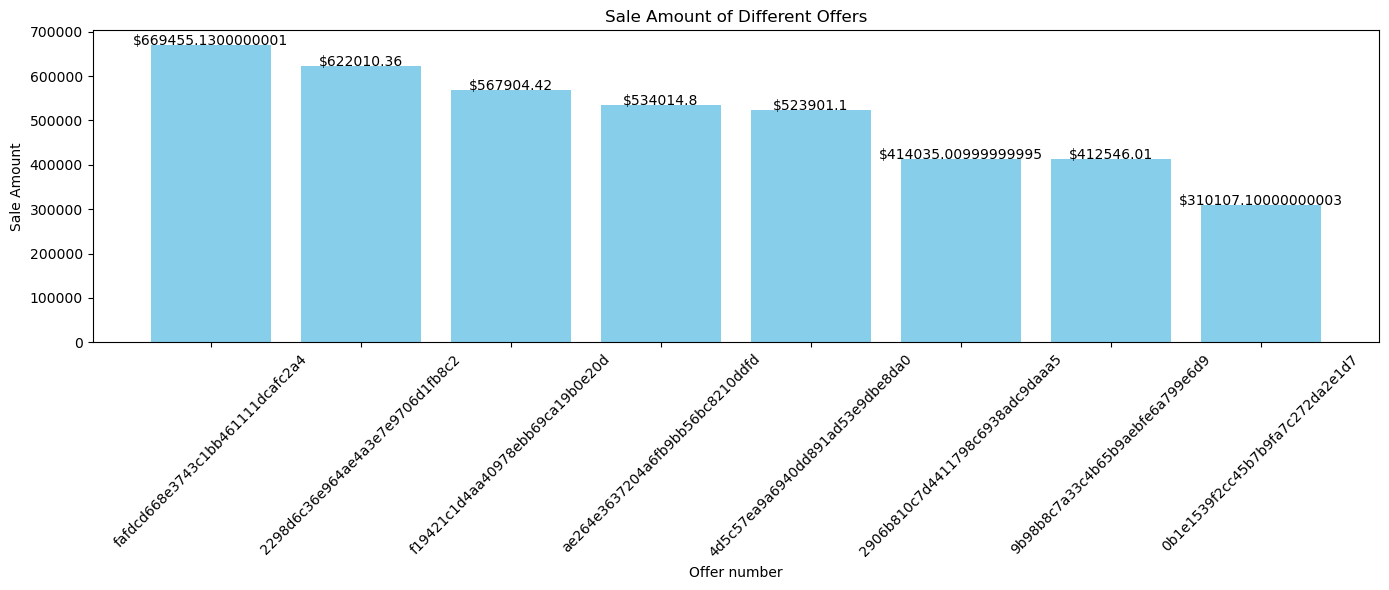

,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,669455.13
1,2298d6c36e964ae4a3e7e9706d1fb8c2,622010.36
6,f19421c1d4aa40978ebb69ca19b0e20d,567904.42
5,ae264e3637204a6fb9bb56bc8210ddfd,534014.80
3,4d5c57ea9a6940dd891ad53e9dbe8da0,523901.10
2,2906b810c7d4411798c6938adc9daaa5,414035.01
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,412546.01
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,310107.10


In [32]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_sales = transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()
        offer_gain.append([offer_id, offer_sales])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    
    plt.figure(figsize=(14, 6))
    plt.bar(offer_value['offer_id'], offer_value['gain'], color='skyblue')
    plt.title('Sale Amount of Different Offers')
    plt.xlabel('Offer number')
    plt.ylabel('Sale Amount')
    
    # Adding data labels
    for i, value in enumerate(offer_value['gain']):
        plt.text(i, value + 100, f"${value}", ha='center')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return offer_value

best_sale_offer(full_df)


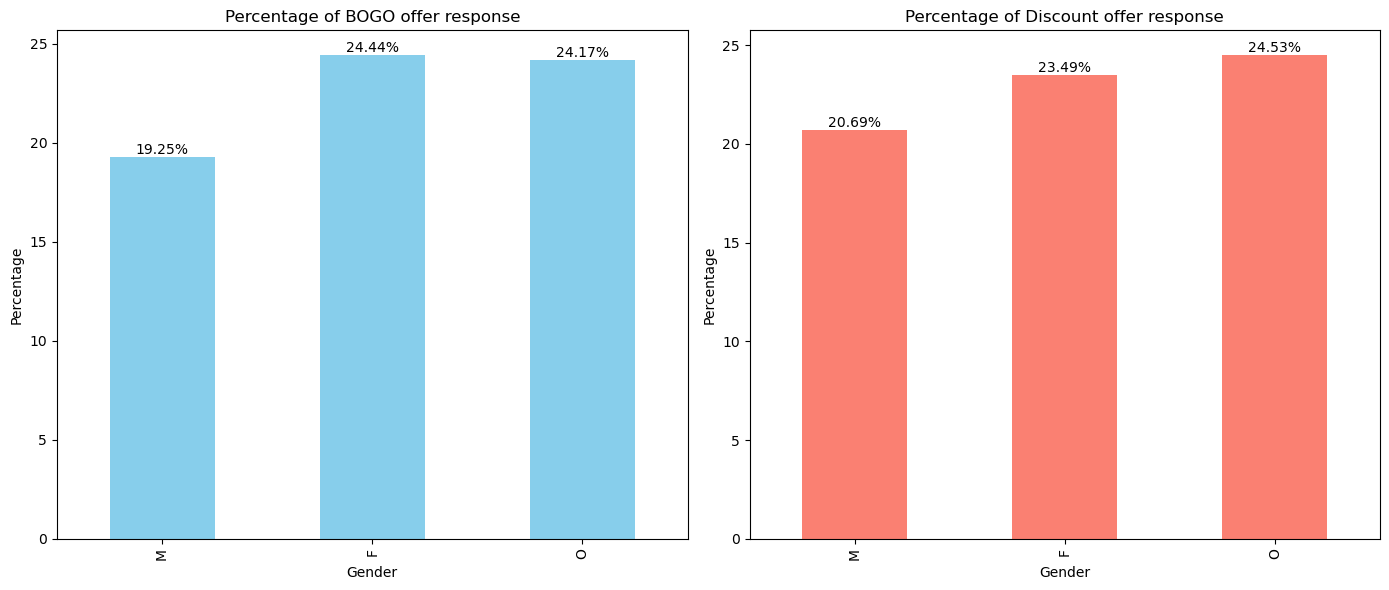

In [33]:
def gender_offer(full_df, portfolio, profile):
    '''
    Find out which type of offer (bogo/discount) attracts most to different genders.
    Return with plotted bar charts for each offer type with data labels.
    '''
    
    # Initialize the gender response and the gender sent dataframes
    gender_response = pd.DataFrame(data=[[0, 0], [0, 0], [0, 0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0, 0], [0, 0], [0, 0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # Count the number of offers completed based on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type'] == offer_type]['id']:
            # Count the total number of customers who responded to our offers
            gender_response[offer_type] = gender_response[offer_type].add(
                profile[profile['id'].isin(full_df[full_df[offer_id] > 0].index)]['gender'].value_counts(), fill_value=0)
            # Count the total number of offers sent
            gender_sent[offer_type] = gender_sent[offer_type].add(
                profile[profile['id'].isin(full_df[full_df[offer_id] >= 0].index)]['gender'].value_counts(), fill_value=0)
        
    # Calculate the percentage of customer response for BOGO offers and plot the bar chart
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # BOGO Offer Plot
    bogo_plot = (gender_response['bogo'] / gender_sent['bogo'] * 100).plot(kind='bar', title='Percentage of BOGO offer response', ax=axs[0], color='skyblue')
    bogo_plot.set_xlabel("Gender")
    bogo_plot.set_ylabel("Percentage")
    
    # Add data labels to the bars
    for index, value in enumerate(gender_response['bogo'] / gender_sent['bogo'] * 100):
        bogo_plot.text(index, value, str(round(value, 2)) + '%', ha='center', va='bottom')
    
    # Discount Offer Plot
    discount_plot = (gender_response['discount'] / gender_sent['discount'] * 100).plot(kind='bar', title='Percentage of Discount offer response', ax=axs[1], color='salmon')
    discount_plot.set_xlabel("Gender")
    discount_plot.set_ylabel("Percentage")
    
    # Add data labels to the bars
    for index, value in enumerate(gender_response['discount'] / gender_sent['discount'] * 100):
        discount_plot.text(index, value, str(round(value, 2)) + '%', ha='center', va='bottom')
    
    plt.tight_layout()  # Adjust layout
    plt.show()  # Show the plots

# Assuming you have the necessary dataframes 'portfolio' and 'profile' defined elsewhere
# and 'full_df' contains information about offer completion
gender_offer(full_df, portfolio, profile)


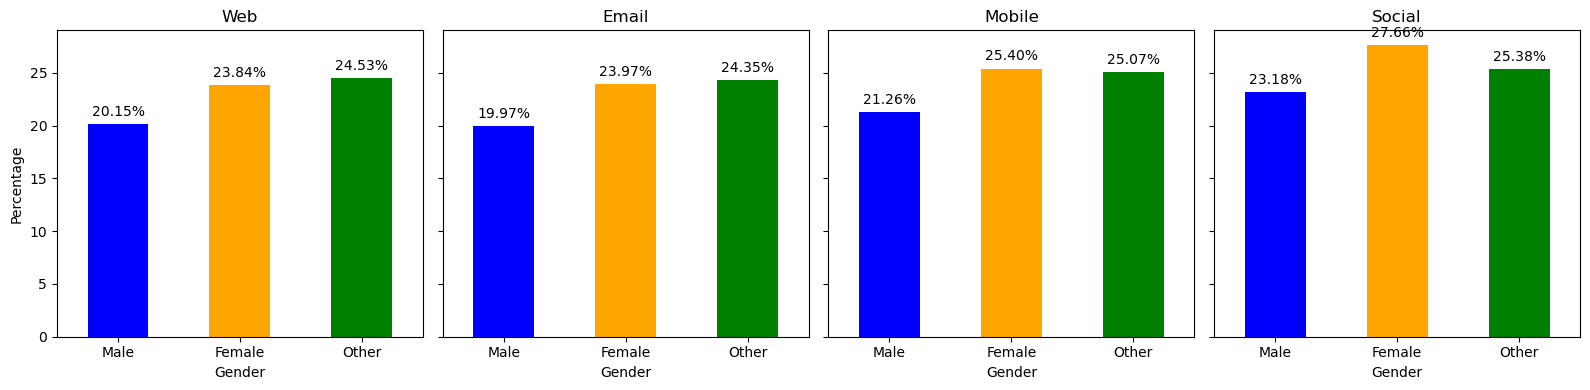

In [34]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with plotted bar charts for each channel with different colors and data labels
    '''
    
    # Initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    # We count the number of offer completed base on the customer gender
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['id']:
            # Count the total number of customers who responded to our offers
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # Count the total number of offers sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

    # Plotting bar charts for each channel
    for i, channel_type in enumerate(['web', 'email', 'mobile', 'social']):
        color_map = {'M': 'blue', 'F': 'orange', 'O': 'green'}
        (gender_response[channel_type] / gender_sent[channel_type] * 100).plot(kind='bar', ax=axs[i], title=f'{channel_type.capitalize()}', color=[color_map.get(x, '#333333') for x in gender_response.index])

        # Add data labels
        for index, value in enumerate(gender_response[channel_type] / gender_sent[channel_type] * 100):
            axs[i].text(index, value + 0.5, f'{value:.2f}%', ha='center', va='bottom')

        axs[i].set_xlabel("Gender")
        axs[i].set_ylabel("Percentage")
        axs[i].set_xticklabels(['Male', 'Female', 'Other'], rotation=0)

    plt.tight_layout()
    plt.show()

gender_offer_channel(full_df)
